In [1]:
import wandb
import yaml
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
from src.tools import check_file_path

url="vincekillerz/base-traversability-estimation-v2/saved_model:v30"
name="asymformer"
run = wandb.init() 
            
artifact = run.use_artifact(url, type='model')
artifact_dir = artifact.download()
config = yaml.safe_load(open(check_file_path(artifact_dir, 'config.yaml')))
model_path = check_file_path(artifact_dir, 'trained_model.pth')
# Some standard imports


c:\Users\Gharib\Desktop\vincent\master_thesis_v2\venv3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincekillerz. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact saved_model:v30, 126.27MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.5


In [2]:
from src.models.model_builder import model_builder


device = config['ml_orchestrator']['device']
model = model_builder(config['model_builder'])
model.to(device)

# load model
print(model_path)
model.load_state_dict(torch.load(model_path))
model.eval()

c:\Users\Gharib\Desktop\vincent\master_thesis_v2\artifacts\saved_model-v30\trained_model.pth


B0_T(
  (down_sample_1): down_sample_block(
    (depth_stem): OverlapPatchEmbed(
      (proj): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (rgb_stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (rgb_layer): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
      

: 

In [ ]:
import torch
import torch_tensorrt
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))
You are now ready to perform inference on this model.



In [3]:
image = torch.randn(1, 3, 480, 640).to(device)
depth = torch.randn(1, 1, 480, 640).to(device)
torch_out = model(image,depth)

# Export the model
torch.onnx.export(model,               # model being run
                  (image,depth),                         # model input (or a tuple for multiple inputs)
                  name+'.onnx',   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input_rgb','input_depth'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input_rgb' : {0 : 'batch_size'},    # variable length axes
                                'input_depth' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

c:\Users\Gharib\Desktop\vincent\master_thesis_v2\venv3\lib\site-packages\torch\onnx\symbolic_helper.py:833: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


In [4]:
import onnx

onnx_model = onnx.load(name+".onnx")
onnx.checker.check_model(onnx_model)

In [22]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(name+".onnx", providers=[("CUDAExecutionProvider")])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {
    ort_session.get_inputs()[0].name: to_numpy(image),
    ort_session.get_inputs()[1].name: to_numpy(depth)
    
}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-01, atol=1e-01)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


cuda


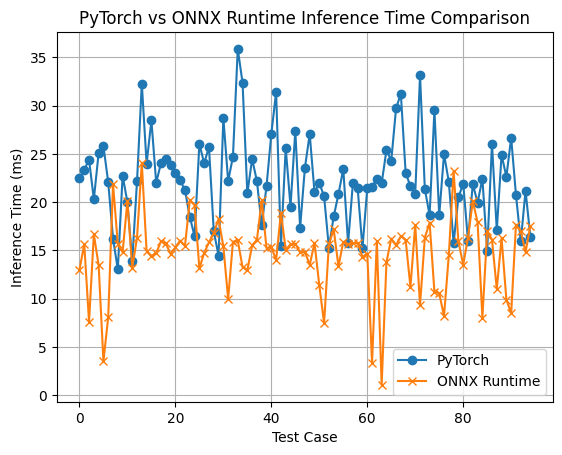

ONNX mean inference time: 14.70 ms
PyTorch mean inference time: 22.29 ms
ONNX is 1.52x faster than PyTorch!


In [23]:
import time
import matplotlib.pyplot as plt
# Lists to store execution times
pytorch_times = []
onnx_times = []
print(device)
for i in range(100):  # Conducting 10 tests
    # Generate random inputs
    x = torch.randn(1, 3, 480, 640, requires_grad=True).to(device)
    y = torch.randn(1, 1, 480, 640, requires_grad=True).to(device)

    # Measure PyTorch inference time
    torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        _ = model(x, y)  # Replace '_' with your model's actual output variable if you want to use it
    torch.cuda.synchronize()
    end_time = time.time()
    pytorch_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # # Prepare inputs for ONNX Runtime
    # ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x), 
    #               ort_session.get_inputs()[1].name: to_numpy(y)}
    io_binding = ort_session.io_binding()
    io_binding.bind_input(
        name="input_rgb",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(x.shape),
        buffer_ptr=x.data_ptr(),
    )
    io_binding.bind_input(
        name="input_depth",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(y.shape),
        buffer_ptr=y.data_ptr(),
    )
    logit_output_shape = (1,1,480, 640)
    logit_output = torch.empty(logit_output_shape, dtype=torch.float32, device='cuda:0').contiguous()
    io_binding.bind_output(
        name="output",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(logit_output.shape),
        buffer_ptr=logit_output.data_ptr()
    )
    # Measure ONNX Runtime inference time

    start_time = time.time()
    _ = ort_session.run_with_iobinding(io_binding)  # Replace '_' with your ONNX model's actual output variable if you want to use it
 
    end_time = time.time()

    onnx_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

pytorch_times = pytorch_times[5:]
onnx_times = onnx_times[5:]
# Plot comparison of execution times
plt.plot(pytorch_times, label='PyTorch', marker='o')
plt.plot(onnx_times, label='ONNX Runtime', marker='x')
plt.legend()
plt.xlabel('Test Case')
plt.ylabel('Inference Time (ms)')
plt.title('PyTorch vs ONNX Runtime Inference Time Comparison')
plt.grid(True)
plt.show()
# compare mean
pytorch_mean = np.mean(pytorch_times)
onnx_mean = np.mean(onnx_times)
print(f"ONNX mean inference time: {onnx_mean:.2f} ms")
print(f"PyTorch mean inference time: {pytorch_mean:.2f} ms")
print(f"ONNX is {pytorch_mean/onnx_mean:.2f}x faster than PyTorch!")

In [1]:
import onnx
import numpy as np

def is_overflow_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)
    fp16_data = original_data.astype(np.float16)
    back_converted_data = fp16_data.astype(np.float32)

    diff = np.abs(back_converted_data - original_data)
    return np.any(diff > 0.001)

def is_truncated_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)

    return np.any(np.abs(original_data) <= 0.0000001)  # Check if the FP16 weight is zero



model = onnx.load("asymformer.onnx")  # Load ONNX model
overflow_list=[]
for node in model.graph.node:
    if node.input:  # Check network layer which has 'input'
        for input_name in node.input:
            weight = next((init for init in model.graph.initializer if init.name == input_name), None)
            if weight is not None:  # Make sure the layer has 'weight'
                weights = onnx.numpy_helper.to_array(weight)
                if is_overflow_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight overflow in fp16")
                    overflow_list.append(node.name)
                if is_truncated_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight truncated in fp16")
                    overflow_list.append(node.name)

print('个数：',len(overflow_list))

Node /down_sample_1/depth_layer.1/attn/sr/Conv (Conv): Weight truncated in fp16
Node /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_2/rgb_layer/rgb_layer.2/Mul (Mul): Weight overflow in fp16
Node /down_sample_2/depth_layer.0/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/depth_layer.1/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/SCC/conv1/Conv (Conv): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_3/rgb_stem/rgb_stem.1/Conv (Conv): Weight overflow in fp16
Node /down_sample_3/rgb_layer/rgb_layer.0/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_3/rgb_layer/rgb_layer.3/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_3/rgb_layer/rgb_layer.4/pwconv1/MatMul (Ma

C:\Users\Gharib\AppData\Local\Temp\ipykernel_6292\2025094908.py:6: RuntimeWarning: overflow encountered in cast
  fp16_data = original_data.astype(np.float16)


Node /down_sample_4/rgb_layer/rgb_layer.0/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.0/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/dwconv/Conv (Conv): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/norm/Add_1 (Add): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/dwconv/Conv (Conv): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/norm/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv2/MatMu

In [2]:
import os
import tensorrt as trt

def build_engine(onnx_file_path, engine_file_path, overflow_list, flop=16):
    trt_logger = trt.Logger(trt.Logger.WARNING)  # trt.Logger.ERROR
    builder = trt.Builder(trt_logger)
    builder_config = builder.create_builder_config()
    
    network = builder.create_network(
        1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    )
    
    parser = trt.OnnxParser(network, trt_logger)
    # parse ONNX
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print('ERROR: Failed to parse the ONNX file.')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
    print("Completed parsing ONNX file")

    # default = 1 for fixed batch size
    builder.max_batch_size = 1
    # set mixed flop computation for the best performance
    
    builder_config.set_flag(trt.BuilderFlag.FP16)

    if os.path.isfile(engine_file_path):
        try:
            os.remove(engine_file_path)
        except Exception:
            print("Cannot remove existing file: ",
                engine_file_path)

    print("Creating Tensorrt Engine")

    for layer in network:
        for layer_name in overflow_list:
            if layer_name in layer.name:
                layer.precision = trt.float32
                print(f'Network Layer: {layer.name}, {layer.type}, {layer.precision}, is_set: {layer.precision_is_set}')

    config = builder.create_builder_config()
    config.set_tactic_sources(1 << int(trt.TacticSource.CUBLAS))
    config.max_workspace_size = 2 << 30
    config.set_flag(trt.BuilderFlag.FP16)
    config.set_flag(trt.BuilderFlag.STRICT_TYPES)

    print('config.flags: ', config.flags)
    
    engine = builder.build_engine(network, config)
    with open(engine_file_path, "wb") as f:
        f.write(engine.serialize())
    print("Serialized Engine Saved at: ", engine_file_path)
    return engine

In [3]:
ONNX_SIM_MODEL_PATH = 'asymformer.onnx'
TENSORRT_ENGINE_PATH_PY = 'asymformer.engine'

build_engine(ONNX_SIM_MODEL_PATH, TENSORRT_ENGINE_PATH_PY, overflow_list)

Completed parsing ONNX file
Creating Tensorrt Engine
Network Layer: /down_sample_1/depth_layer.1/attn/sr/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.2/Mul, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/depth_layer.0/attn/kv/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/depth_layer.1/attn/kv/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/conv1/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_3/rgb_stem/rgb_stem.1/Conv, Lay

C:\Users\Gharib\AppData\Local\Temp\ipykernel_6292\2986593341.py:24: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  builder.max_batch_size = 1
C:\Users\Gharib\AppData\Local\Temp\ipykernel_6292\2986593341.py:46: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 2 << 30
C:\Users\Gharib\AppData\Local\Temp\ipykernel_6292\2986593341.py:52: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


AttributeError: 'NoneType' object has no attribute 'serialize'